
# **Marketing Campaign Customer Analysis and Insights**


# **Introduction**

This project analyzes customer data from a marketing campaign to understand factors influencing customer purchasing behavior and campaign responsiveness. By examining demographics, spending patterns, and campaign acceptance, the analysis aims to provide actionable insights that can help optimize marketing strategies and improve campaign effectiveness.


**Project Objectives**:

 - Clean and preprocess the dataset by addressing missing values, duplicates, and formatting issues.

 - Segment customers based on demographic attributes and purchasing behavior.

 - Analyze campaign acceptance rates across different customer groups.

 - Investigate the relationship between income, age, and total spending.

 - Compare purchasing behavior between customers with and without children.

 - Visualize spending trends across various product categories.

 - Apply statistical tests to validate the influence of demographic and behavioral factors on campaign response.




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind, f_oneway

In [2]:
# Load dataset
df = pd.read_csv(r'/content/marketing_campaign.csv', sep='\t')

In [3]:
print(df.shape)
df.head()

(2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

# **Data Cleaning**

In [5]:
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 0


In [6]:
print("Before Impuation Null Values:", df['Income'].isnull().sum())
df['Income'] = df['Income'].fillna(df['Income'].median())
print("After Imputation Null Values:", df['Income'].isnull().sum())

Before Impuation Null Values: 24
After Imputation Null Values: 0


In [7]:
# Convert date columns
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
df['Dt_Customer'].dtypes

dtype('<M8[ns]')

In [8]:
# Handle missing values
df.dropna(inplace=True)

In [9]:
# Feature engineering: Age
from datetime import datetime
df['Age'] = datetime.now().year - df['Year_Birth']

In [10]:
# Categorize Income into quartiles
df['IncomeGroup'] = pd.qcut(df['Income'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

In [11]:
# Total spending on products
df['TotalSpend'] = df[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].sum(axis=1)

In [12]:
df['Marital_Status'].value_counts()

,count
Marital_Status,
Married,864
Together,580
Single,480
Divorced,232
Widow,77
Alone,3
Absurd,2
YOLO,2


In [13]:
# Clean Marital_Status categories
df['Marital_Status'] = df['Marital_Status'].replace({'Alone': 'Other','YOLO': 'Other','Absurd': 'Other'})

In [14]:
# Customers with kids
df['Has_Children'] = np.where((df['Kidhome'] + df['Teenhome']) > 0, 'Yes', 'No')

In [15]:
#Total Campaigns Accepted
campaigns = ['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']
df['TotalCampaignsAccepted'] = df[campaigns].sum(axis=1)
df['AcceptedAnyCampaign'] = df['TotalCampaignsAccepted'] > 0

In [16]:
df['Education']=df['Education'].replace({"2n Cycle":"Diploma"})

In [17]:
df = df.rename(columns={
    'Recency': 'Days_Wout_Purchase',
    'Dt_Customer': 'Date_Since_Customer',
    'MntWines': 'Wine',
    'MntFruits': 'Fruits',
    'MntMeatProducts': 'Meat',
    'MntFishProducts': 'Fish',
    'MntSweetProducts': 'Sweets',
    'MntGoldProds': 'Gold',
    'AcceptedCmp1': 'Campaign 1',
    'AcceptedCmp2': 'Campaign 2',
    'AcceptedCmp3': 'Campaign 3',
    'AcceptedCmp4': 'Campaign 4',
    'AcceptedCmp5': 'Campaign 5'
})

In [18]:
# oldest customers info
oldest_date = df['Date_Since_Customer'].min()
oldest_customers = df[df['Date_Since_Customer'] == oldest_date]

print(f"Oldest customer(s) joined on {oldest_date.strftime('%Y-%m-%d')}:")
for idx, row in oldest_customers.iterrows():
    print(f" Customer ID {row['ID']} with most recent transaction {row['Days_Wout_Purchase']} days ago")

Oldest customer(s) joined on 2012-07-30:
 Customer ID 6653 with most recent transaction 72 days ago


In [19]:
# newest customers info
newest_date = df['Date_Since_Customer'].max()
newest_customers = df[df['Date_Since_Customer'] == newest_date]

print(f"\nNewest customer(s) joined on {newest_date.strftime('%Y-%m-%d')}:")
for idx, row in newest_customers.iterrows():
    print(f" Customer ID {row['ID']} with most recent transaction {row['Days_Wout_Purchase']} days ago")


Newest customer(s) joined on 2014-06-29:
 Customer ID 7300 with most recent transaction 50 days ago
 Customer ID 453 with most recent transaction 1 days ago


# **Data Visualization**

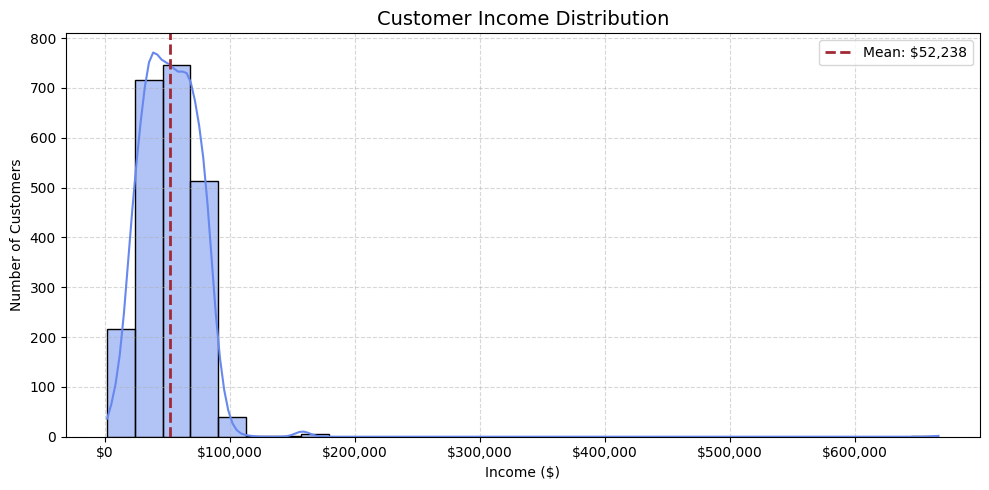

In [20]:
# Income Distribution with KDE and Mean line
mean_income = df['Income'].mean()
plt.figure(figsize=(10, 5))
sns.histplot(df['Income'], kde=True, color=sns.color_palette("coolwarm")[0], bins=30)
plt.axvline(mean_income, color="#a02933", linestyle='--', linewidth=2, label=f'Mean: ${mean_income:,.0f}')
plt.title('Customer Income Distribution',fontsize=14)
plt.xlabel('Income ($)')
plt.ylabel('Number of Customers')
plt.legend()
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

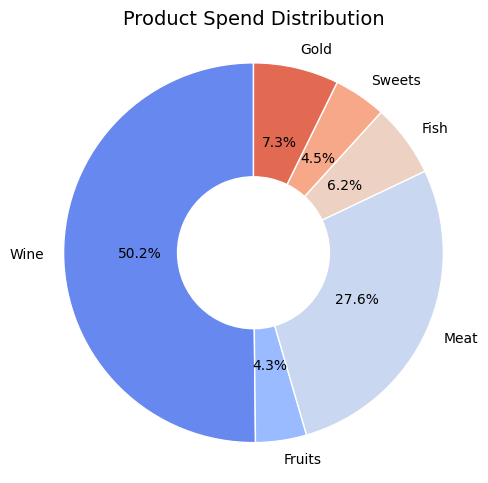

In [21]:
# Product Spend Distribution
product_cols = ['Wine','Fruits','Meat','Fish','Sweets','Gold']
product_tot = df[product_cols].sum()
plt.figure(figsize=(5, 5))
plt.pie(product_tot, labels=product_tot.index, autopct='%1.1f%%', startangle=90,
        wedgeprops={'width': 0.6, 'edgecolor': 'white'}, textprops={'fontsize': 10},colors=sns.color_palette('coolwarm'))
plt.title('Product Spend Distribution', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()

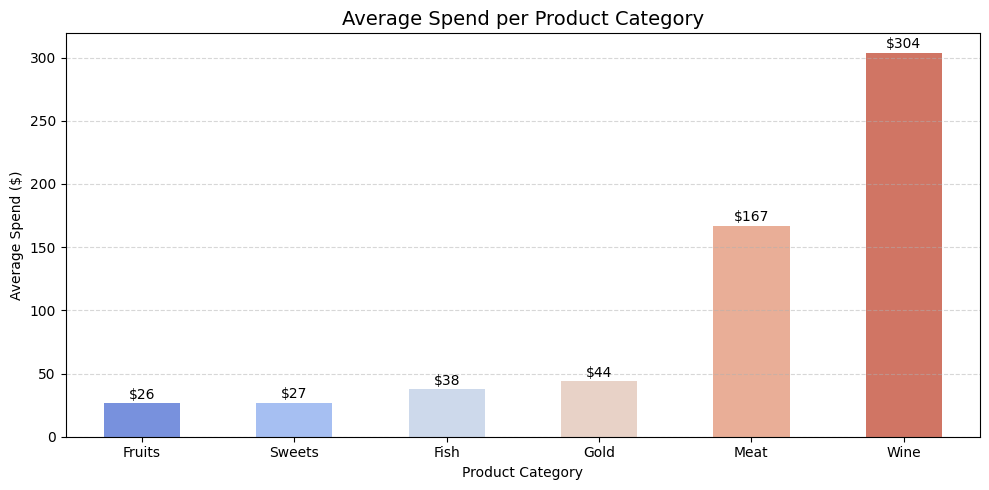

In [22]:
# Average Spend per Product Category
product_avg = df[product_cols].mean().sort_values()
plt.figure(figsize=(10, 5))
sns.barplot(x=product_avg.index, y=product_avg.values, palette='coolwarm', width=0.5, hue=product_avg.index)
for i, value in enumerate(product_avg.values):
    plt.text(i, value + 1, f"${value:.0f}", ha='center', va='bottom', fontsize=10)
plt.title('Average Spend per Product Category', fontsize=14)
plt.xlabel('Product Category')
plt.ylabel('Average Spend ($)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

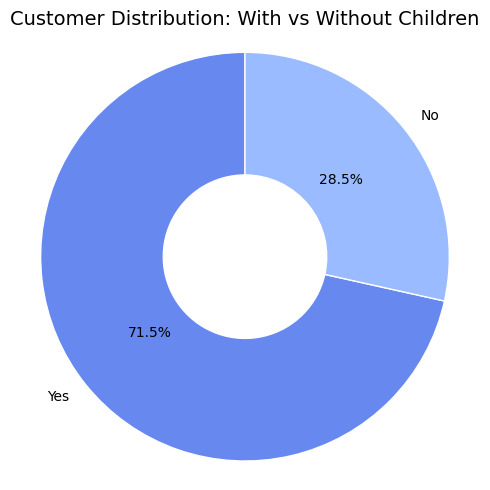

In [23]:
# Pie chart: Customers with Children
plt.figure(figsize=(5,5))
child_counts = df['Has_Children'].value_counts()
plt.pie(child_counts,labels=child_counts.index,autopct='%1.1f%%',startangle=90, colors=sns.color_palette("coolwarm"),wedgeprops={'width': 0.6, 'edgecolor': 'white'},textprops={'fontsize': 10})
plt.title('Customer Distribution: With vs Without Children',fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()


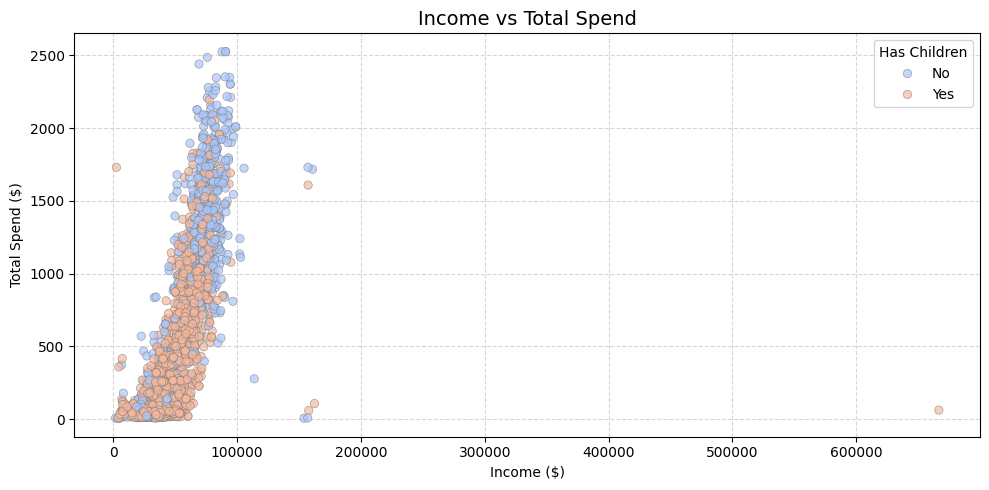

In [24]:
# Income vs Total Spend
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='Income', y='TotalSpend', hue='Has_Children', palette='coolwarm', alpha=0.7,edgecolor='gray',linewidth=0.5 )
plt.title('Income vs Total Spend', fontsize=14)
plt.xlabel('Income ($)')
plt.ylabel('Total Spend ($)')
plt.grid(linestyle='--', alpha=0.5)
plt.legend(title='Has Children')
plt.tight_layout()
plt.show()

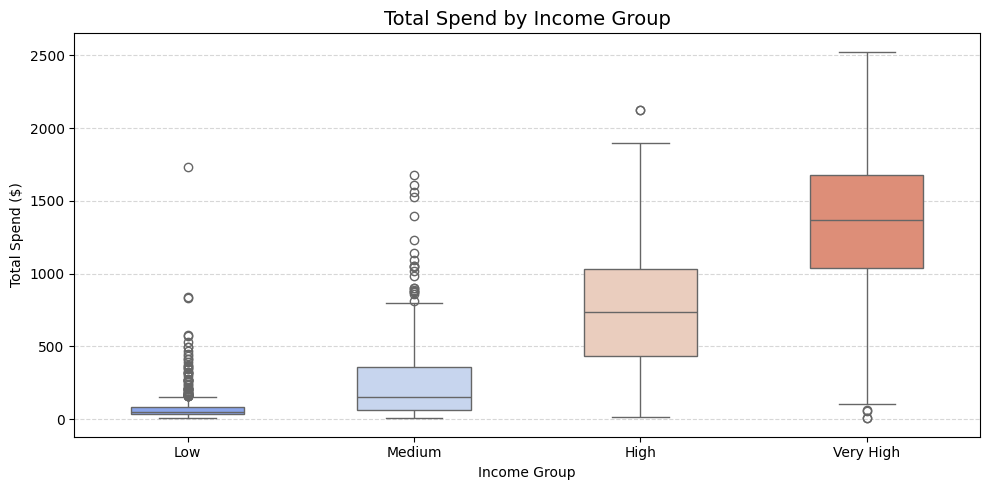

In [25]:
# Spending distribution by income group
plt.figure(figsize=(10, 5))
sns.boxplot(x='IncomeGroup', y='TotalSpend', data=df, palette='coolwarm',hue='IncomeGroup', width=0.5)
plt.title('Total Spend by Income Group', fontsize=14)
plt.xlabel('Income Group')
plt.ylabel('Total Spend ($)')
plt.grid(axis='y',linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

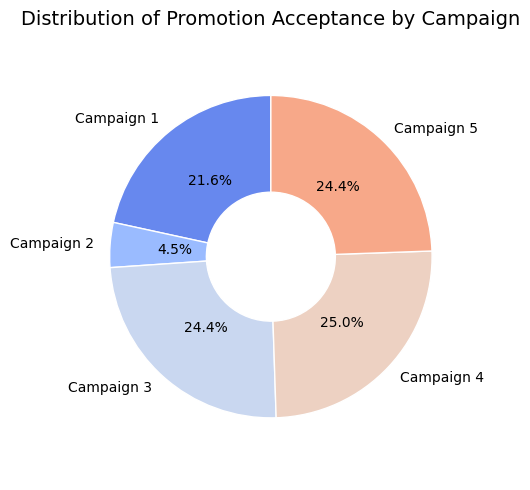

In [26]:
# Promotion Acceptance by Campaign
promotion_cols = ['Campaign 1', 'Campaign 2', 'Campaign 3', 'Campaign 4', 'Campaign 5']
promotion_tot = df[promotion_cols].sum()
plt.figure(figsize=(5,5))
plt.pie(promotion_tot, labels=promotion_tot.index, autopct='%1.1f%%', startangle=90,
        wedgeprops={'width': 0.6, 'edgecolor': 'white'}, textprops={'fontsize': 10},colors=sns.color_palette('coolwarm'))
plt.title('Distribution of Promotion Acceptance by Campaign',fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [27]:
# Campaign Effectiveness Analysis
accepted = df[df['AcceptedAnyCampaign'] == 1]
not_accepted = df[df['AcceptedAnyCampaign'] == 0]
print("Average Total Spend by Customers Who Accepted Campaigns:", round(accepted['TotalSpend'].mean(), 2))
print("Average Total Spend by Customers Who Did Not Accept Any Campaigns:", round(not_accepted['TotalSpend'].mean(), 2))

Average Total Spend by Customers Who Accepted Campaigns: 1097.04
Average Total Spend by Customers Who Did Not Accept Any Campaigns: 477.81


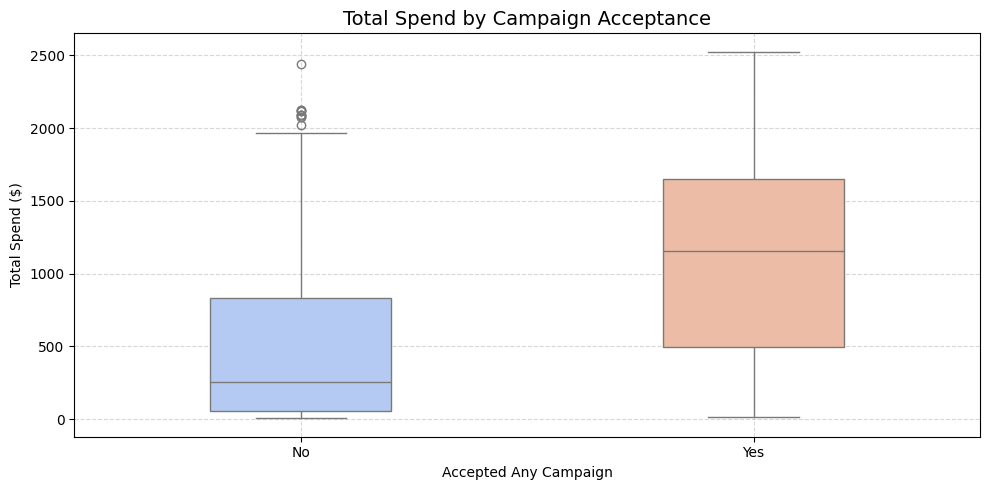

In [28]:
df_plot = df.copy()
df_plot['AcceptedAnyCampaign'] = df_plot['AcceptedAnyCampaign'].map({True: 'Yes', False: 'No'})
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_plot, x='AcceptedAnyCampaign', y='TotalSpend', palette='coolwarm', width=0.4, hue='AcceptedAnyCampaign')
plt.title('Total Spend by Campaign Acceptance',fontsize=14)
plt.xlabel('Accepted Any Campaign')
plt.ylabel('Total Spend ($)')
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [29]:
# Stacked Bar Chart Function
def stackbar(data, title, xlabel, ylabel, palette=None):
    categories = data.index
    values = data.values
    columns = data.columns
    fig, ax = plt.subplots(figsize=(10,5))
    cum_sum = np.zeros(len(categories))
    if palette is None:
        palette = sns.color_palette("coolwarm", n_colors=len(columns))
    for i, col in enumerate(columns):
        ax.bar(categories, values[:, i], bottom=cum_sum, label=col, color=palette[i])
        cum_sum += values[:, i]
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

In [30]:
# Create age groups for analysis
bins = [0, 30, 40, 50, 60, 70, 100]
labels = ['<30', '30-39', '40-49', '50-59', '60-69', '70+']
df['Age_group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

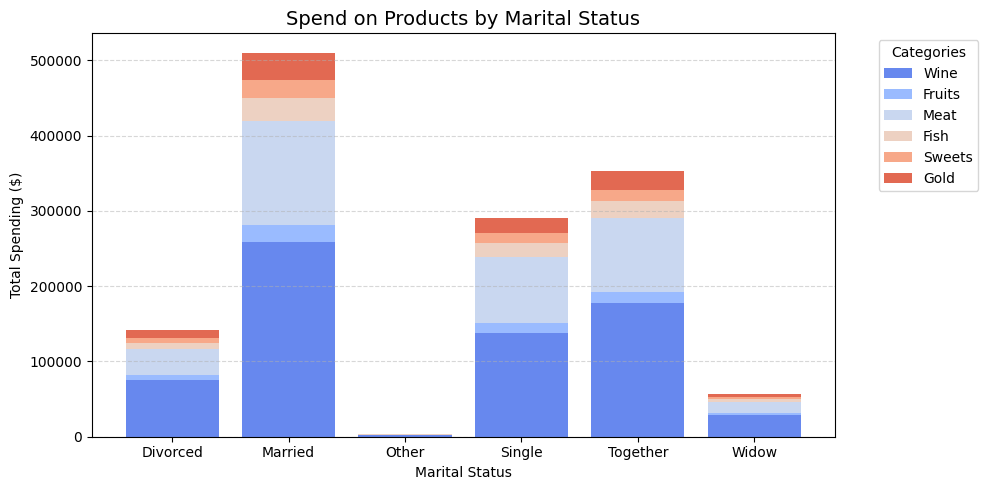

In [31]:
# Spend by Marital Status
group1 = df.groupby('Marital_Status')[product_cols].sum()
stackbar(group1, 'Spend on Products by Marital Status', 'Marital Status', 'Total Spending ($)')

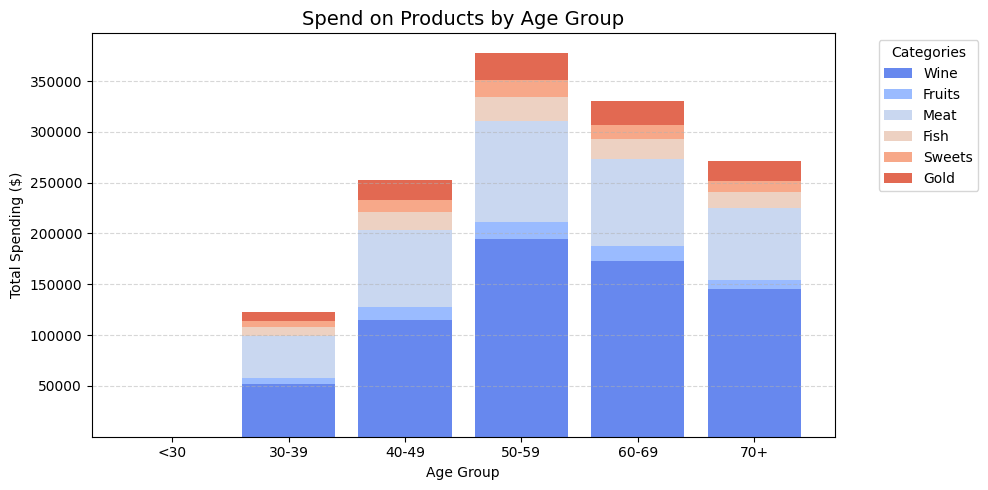

In [32]:
# Spend by Age Group
group2 = df.groupby('Age_group',observed=True)[product_cols].sum()
stackbar(group2, 'Spend on Products by Age Group', 'Age Group', 'Total Spending ($)')

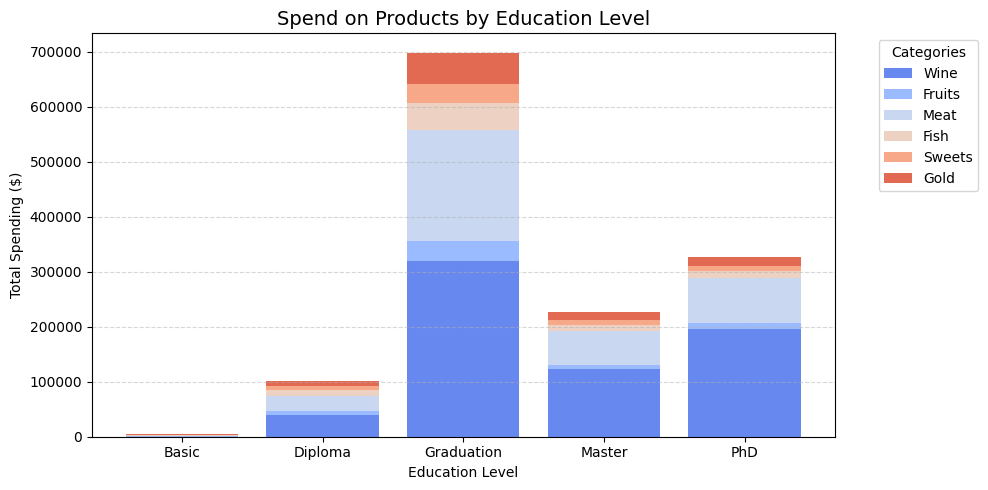

In [33]:
# Spend by Education Level
group3 = df.groupby('Education')[product_cols].sum()
stackbar(group3, 'Spend on Products by Education Level', 'Education Level', 'Total Spending ($)')

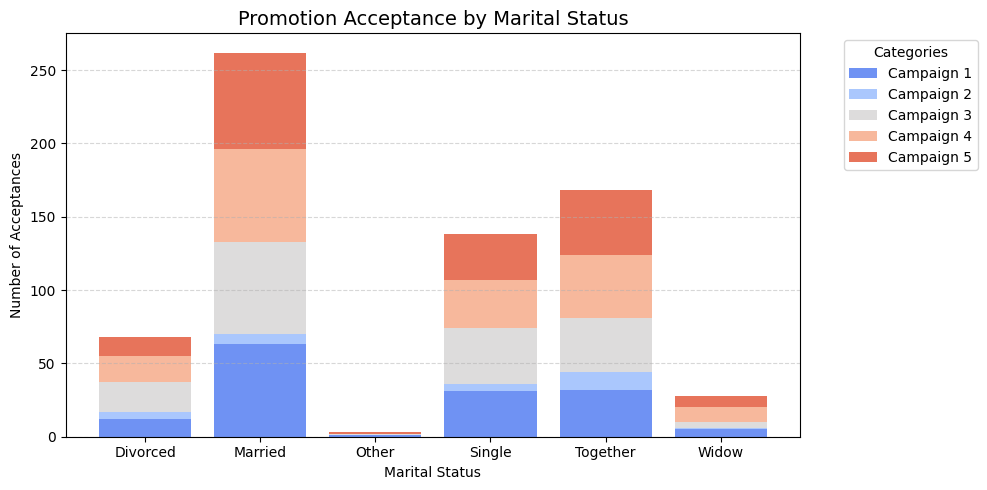

In [34]:
# Promotion Acceptance by Marital Status
promo_cols = ['Campaign 1','Campaign 2','Campaign 3','Campaign 4','Campaign 5']
group4 = df.groupby('Marital_Status')[promo_cols].sum()
stackbar(group4, 'Promotion Acceptance by Marital Status', 'Marital Status', 'Number of Acceptances')

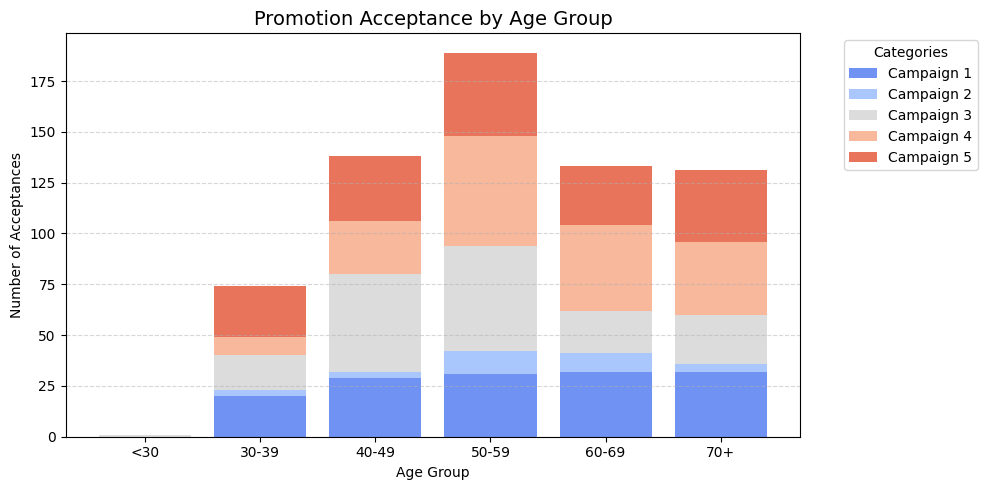

In [35]:
group5 = df.groupby('Age_group', observed=True)[promo_cols].sum()
stackbar(group5, 'Promotion Acceptance by Age Group', 'Age Group', 'Number of Acceptances')

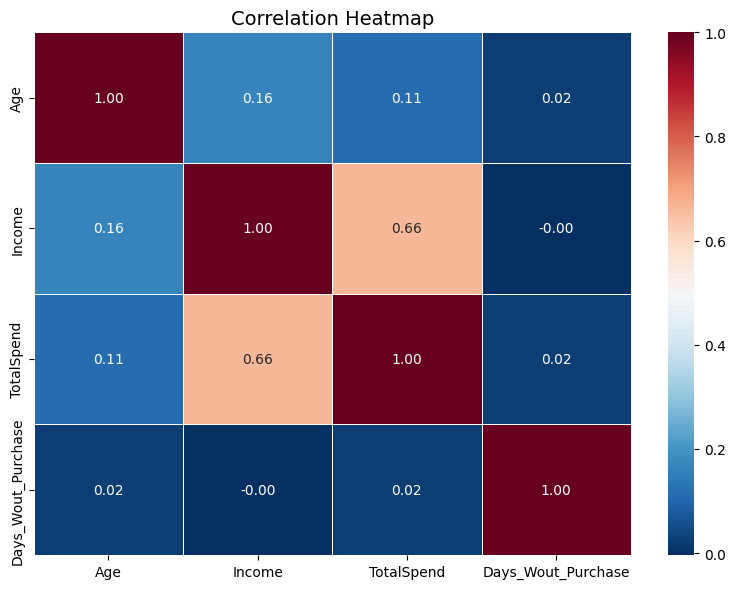

In [36]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
corr = df[['Age', 'Income', 'TotalSpend', 'Days_Wout_Purchase']].corr()
sns.heatmap(corr, annot=True, cmap='RdBu_r', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap',fontsize=14)
plt.tight_layout()
plt.show()

# **Statistical Tests**

In [37]:
# T-Test: Income vs Campaign Acceptance
accepted = df[df['AcceptedAnyCampaign']]['Income']
not_accepted = df[~df['AcceptedAnyCampaign']]['Income']
t_stat, p_val = ttest_ind(accepted, not_accepted, equal_var=False)
print("\nT-Test: Income vs Campaign Acceptance")
print(f"T = {t_stat:.2f}, p = {p_val:.3f}")
if p_val < 0.05:
    print("Result: Statistically significant difference in average income between customers who accepted campaigns and those who did not (reject null hypothesis).")
else:
    print("Result: No statistically significant difference in average income between customers who accepted campaigns and those who did not (fail to reject null hypothesis).")


T-Test: Income vs Campaign Acceptance
T = 14.60, p = 0.000
Result: Statistically significant difference in average income between customers who accepted campaigns and those who did not (reject null hypothesis).


**Result Interpretation:**

The t-test indicates a highly significant difference in average income between customers who accepted at least one marketing campaign and those who did not. This suggests that customers who engage with campaigns tend to have higher incomes, making income an important factor influencing campaign acceptance.

In [38]:
# Chi-Squared: Marital Status vs Campaign Acceptance
contingency2 = pd.crosstab(df['Marital_Status'], df['AcceptedAnyCampaign'])
chi2, p, dof, _ = chi2_contingency(contingency2)
print("\nChi-Squared Test: Marital Status vs Campaign Acceptance")
print(f"Chi² = {chi2:.2f}, p = {p:.3f}")
if p < 0.05:
    print("Result: Statistically significant association between marital status and campaign acceptance (reject null hypothesis).")
else:
    print("Result: No statistically significant association between marital status and campaign acceptance (fail to reject null hypothesis).")


Chi-Squared Test: Marital Status vs Campaign Acceptance
Chi² = 1.38, p = 0.926
Result: No statistically significant association between marital status and campaign acceptance (fail to reject null hypothesis).


**Result Interpretation:**

The results indicate no statistically significant association between marital status and campaign acceptance. Since the p-value exceeds the common threshold of 0.05, we fail to reject the null hypothesis, indicating that campaign acceptance is not dependent on marital status in this dataset.

In [39]:
# Chi-Squared Test: Children vs Campaign Acceptance
contingency = pd.crosstab(df['Has_Children'], df['AcceptedAnyCampaign'])
chi2, p, dof, ex = chi2_contingency(contingency)
print("\nChi-Squared Test: Has_Children vs Campaign Acceptance")
print(f"Chi² = {chi2:.3f}, p = {p:.3f}, dof = {dof}")
if p < 0.05:
    print("Result: Statistically significant association between having children and campaign acceptance (reject null hypothesis).")
else:
    print("Result: No statistically significant association between having children and campaign acceptance (fail to reject null hypothesis).")


Chi-Squared Test: Has_Children vs Campaign Acceptance
Chi² = 130.014, p = 0.000, dof = 1
Result: Statistically significant association between having children and campaign acceptance (reject null hypothesis).


**Result Interpretation:**

There is a statistically significant association between having children and campaign acceptance. The result indicates that customers with children are significantly more or less likely to accept marketing campaigns compared to customers without children.

In [40]:
#ANOVA: TotalSpend by Education
anova_result = f_oneway(*[df[df['Education'] == edu]['TotalSpend'] for edu in df['Education'].unique()])
print("\nANOVA: TotalSpend by Education")
print(f"F = {anova_result.statistic:.2f}, p = {anova_result.pvalue:.3f}")
if anova_result.pvalue < 0.05:
    print("Result: Statistically significant difference in total spending among different education levels (reject null hypothesis).")
else:
    print("Result: No statistically significant difference in total spending among different education levels (fail to reject null hypothesis).")


ANOVA: TotalSpend by Education
F = 13.85, p = 0.000
Result: Statistically significant difference in total spending among different education levels (reject null hypothesis).


**Result Interpretation:**

The ANOVA results indicate a statistically significant difference in total spending among customers with different education levels. This implies that education background influences spending behavior.

# **Key Insights**

In [51]:
print("\n" + "="*60)
print("📝  KEY INSIGHTS SUMMARY")
print("="*60 + "\n")

# Overall campaign acceptance rate
acceptance_rate = df['AcceptedAnyCampaign'].mean() * 100
print(f"📊 Overall Campaign Acceptance Rate: {acceptance_rate:.1f}% of customers accepted at least one campaign.\n")

# Income & Campaign Engagement
income_accepted = round(df[df['AcceptedAnyCampaign']]['Income'].mean(), 2)
income_not_accepted = round(df[~df['AcceptedAnyCampaign']]['Income'].mean(), 2)
print(f"    Income & Campaign Engagement:")
print(f"    • Customers who accepted campaigns have average income (${income_accepted:,})")
print(f"    • Customers who did not accept campaigns have average income (${income_not_accepted:,})\n")


# Product Category Spending Patterns
top_product = df[product_cols].mean().idxmax()
top_product_avg = df[product_cols].mean().max()
print(f"    Product Category Spending Patterns:")
print(f"    • Highest average spending observed in '{top_product}' (${top_product_avg:.2f} per customer)\n")

# Spending by Parental Status
avg_spend_children = df[df['Has_Children'] == 'Yes']['TotalSpend'].mean()
avg_spend_no_children = df[df['Has_Children'] == 'No']['TotalSpend'].mean()
spend_diff = avg_spend_children - avg_spend_no_children
print(f"    Spending by Parental Status:")
print(f"    • Customers with children spend on average ${avg_spend_children:.2f}")
print(f"    • Customers without children spend on average ${avg_spend_no_children:.2f}\n")

# Age Group Insights
age_group_spend = df.groupby('Age_group', observed=True)['TotalSpend'].mean().sort_index()
highest_age_group = age_group_spend.idxmax()
highest_age_spend = age_group_spend.max()
print(f"    Age Group Spending:")
print(f"    • Age group '{highest_age_group}' shows highest average spending (${highest_age_spend:.2f})\n")

# Campaign Acceptance by Income Group
income_campaign = df.groupby('IncomeGroup', observed=True)['AcceptedAnyCampaign'].mean() * 100
highest_income_group = income_campaign.idxmax()
highest_income_acceptance = income_campaign.max()
print(f"    Campaign Acceptance by Income Group:")
print(f"    • '{highest_income_group}' income group has highest acceptance rate at {highest_income_acceptance:.1f}%\n")


print("🔍 Statistical Test Summaries:\n")

print("- Income shows a statistically significant difference between campaign acceptors and non-acceptors, indicating higher income customers are more responsive.")

print("- No significant association found between marital status and campaign acceptance, suggesting marital status is not a key factor.")

print("- Having children is significantly associated with campaign acceptance, indicating family status influences marketing response.")

print("- Total spending differs significantly across education levels, highlighting education as an influencing factor on customer spending.")

print("="*60 + "\n")



📝  KEY INSIGHTS SUMMARY

📊 Overall Campaign Acceptance Rate: 20.7% of customers accepted at least one campaign.

    Income & Campaign Engagement:
    • Customers who accepted campaigns have average income ($65,135.72)
    • Customers who did not accept campaigns have average income ($48,877.45)

    Product Category Spending Patterns:
    • Highest average spending observed in 'Wine' ($303.94 per customer)

    Spending by Parental Status:
    • Customers with children spend on average $406.58
    • Customers without children spend on average $1106.03

    Age Group Spending:
    • Age group '70+' shows highest average spending ($742.64)

    Campaign Acceptance by Income Group:
    • 'Very High' income group has highest acceptance rate at 42.3%

🔍 Statistical Test Summaries:

- Income shows a statistically significant difference between campaign acceptors and non-acceptors, indicating higher income customers are more responsive.
- No significant association found between marital sta